In [108]:
import sys
import scipy.integrate as integrate
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from scipy.spatial import cKDTree
import concurrent.futures
from time import time

In [ ]:
#@title Open Geometry file
def boundaryfileopen(filename):
    with open(filename, 'r') as fid:
        xb = []
        yb = []

        BC = []
        BC_counter = 1
        counter = 1

        while True:
            line = fid.readline()

            if not line:
                break  # End of file

            if line.strip() == "end":
                BC_counter += 1
            else:
                BC.append(BC_counter)

                splitdata = line.split()

                xb.append(float(splitdata[0]))
                yb.append(float(splitdata[1]))

                counter += 1

    n = len(xb) - (BC_counter - 1)

    xbi = np.zeros(n)
    xbe = np.zeros(n)
    ybi = np.zeros(n)
    ybe = np.zeros(n)
    xm = np.zeros(n)
    ym = np.zeros(n)
    lm = np.zeros(n)
    nx = np.zeros(n)
    ny = np.zeros(n)
    C = np.zeros(n)

    if BC_counter > 1:
        nraw = np.zeros(BC_counter - 1, dtype=int)
        counter1 = 0
        counter2 = 0

        for i in range(len(xb)):
            nraw[BC[i] - 1] += 1

        for i in range(len(nraw)):
            for j in range(nraw[i] - 1):
                xbi[counter1] = xb[counter2]
                xbe[counter1] = xb[counter2 + 1]
                ybi[counter1] = yb[counter2]
                ybe[counter1] = yb[counter2 + 1]
                xm[counter1] = 0.5 * (xb[counter2] + xb[counter2 + 1])
                ym[counter1] = 0.5 * (yb[counter2] + yb[counter2 + 1])
                lm[counter1] = np.sqrt((xb[counter2 + 1] - xb[counter2])**2 + (yb[counter2 + 1] - yb[counter2])**2)
                nx[counter1] = (yb[counter2 + 1] - yb[counter2]) / lm[counter1]
                ny[counter1] = (xb[counter2] - xb[counter2 + 1]) / lm[counter1]
                C[counter1] = i + 1
                counter1 += 1
                counter2 += 1
            counter2 += 1
    else:
        for i in range(n):
            xbi[i] = xb[i]
            xbe[i] = xb[i + 1]
            ybi[i] = yb[i]
            ybe[i] = yb[i + 1]
            xm[i] = 0.5 * (xb[i] + xb[i + 1])
            ym[i] = 0.5 * (yb[i] + yb[i + 1])
            lm[i] = np.sqrt((xb[i + 1] - xb[i])**2 + (yb[i + 1] - yb[i])**2)
            nx[i] = (yb[i + 1] - yb[i]) / lm[i]
            ny[i] = (xb[i] - xb[i + 1]) / lm[i]

    return n, xbi, xbe, ybi, ybe, xm, ym, lm, nx, ny, C

In [ ]:
#@title Calculate Area
# Function to calculate the area of a polygon
def calcArea(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


In [ ]:
#@title Calculate F, G2

def calcF(xm, ym, xk, yk, nkx, nky, lk):
    integrand = lambda t: intf(t, xm, ym, xk, yk, nkx, nky, lk)
    F, _ = integrate.quad(integrand, 0, 1)
    return (lk / (4.0 * np.pi)) * F

def intf(t, xm, ym, xk, yk, nkx, nky, lk):
    dx = -nky * lk
    dy = nkx * lk
    return np.log((xk + t * dx - xm)**2 + (yk + t * dy - ym)**2)

def calcG2(xm, ym, xk, yk, nkx, nky, lk):
    integrand = lambda t: intg2(t, xm, ym, xk, yk, nkx, nky, lk)
    G2, _ = integrate.quad(integrand, 0, 1, epsabs=1e-4)
    return (lk / (8.0 * np.pi)) * G2

def intg2(t, xm, ym, xk, yk, nkx, nky, lk):
    dx = -nky * lk
    dy = nkx * lk
    return ((xk + t * dx - xm) * nkx + (yk + t * dy - ym) * nky) * (np.log((xk + t * dx - xm)**2 + (yk + t * dy - ym)**2) - 1)

def calcG(xm, ym, xk, yk, nkx, nky, lk):
    integrand = lambda t: intg(t, xm, ym, xk, yk, nkx, nky, lk)
    G, _ = integrate.quad(integrand, 0, 1, epsabs=1e-4)
    return (lk / (2.0 * np.pi)) * G

def intg(t, xm, ym, xk, yk, nkx, nky, lk):
    dx = -nky * lk
    dy = nkx * lk
    return (nkx * (xk + t * dx - xm) + nky * (yk + t * dy - ym)) / ((xk + t * dx - xm)**2 + (yk + t * dy - ym)**2)


In [ ]:
#@title Raycasting
def raycasting(xm, ym, xbi, xbe, ybi, ybe, N):
    n = len(xbi)
    Nx = N
    Ny = N
    xstart = min(np.concatenate([xbi, xbe])) - 1e-4
    ystart = min(np.concatenate([ybi, ybe])) - 1e-4
    xend = max(np.concatenate([xbi, xbe])) + 1e-4
    yend = max(np.concatenate([ybi, ybe])) + 1e-4
    h = max([yend - ystart, xend - xstart]) / N

    x = []
    y = []
    c = 1
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            xp = xstart + i * h
            yp = ystart + j * h

            far = True
            inside = False

            obs = 0
            for k in range(n):
                if ((ybi[k] < yp < ybe[k]) or (ybi[k] > yp > ybe[k])):
                    m = (xbe[k] - xbi[k]) / (ybe[k] - ybi[k])
                    xobs = xbi[k] + m * (yp - ybi[k])
                    if xp > xobs:
                        obs += 1
            if obs % 2 == 1:
                inside = True

            for k in range(n):
                if (xp - xm[k])**2 + (yp - ym[k])**2 < (0.01 * h)**2:
                    far = False
                    break

            if far and inside:
                x.append(xp)
                y.append(yp)
                c += 1

    return np.array(x), np.array(y), h

In [129]:
#@title Calculate Gradient
def SPHDerivative(x, y, neighbour, neighbourlen, h, u):
    W, dWdx, dWdy = KernelCSpline(x, y, neighbour, neighbourlen, h)
    Wn, dWdxn, dWdyn = kernelnorm(W, dWdx, dWdy, x, neighbourlen, h)
    B = CalcB(dWdxn, dWdyn, x, y, neighbour, neighbourlen, h)
    Sdf = SPHCdf(dWdxn, dWdyn, x, u, neighbour, neighbourlen, B, h)
    return Sdf

def KernelCSpline(x, y, neighbour, neighbourlen, h):
    Nsph = len(x)
    s = h
    const = 10 / (7 * np.pi)

    W = [np.zeros(neighbourlen[i]) for i in range(Nsph)]
    dWdx = [np.zeros(neighbourlen[i]) for i in range(Nsph)]
    dWdy = [np.zeros(neighbourlen[i]) for i in range(Nsph)]

    for i in range(Nsph):
        for j in range(neighbourlen[i]):
            dX = x[i] - x[neighbour[i][j]]
            dY = y[i] - y[neighbour[i][j]]
            dr = np.sqrt(dX**2 + dY**2)
            dR = dr / s

            if dR < 1:
                W[i][j] = const * (2/3 - dR**2 + 1/2 * dR**3)
                if i == neighbour[i][j]:
                    dWdx[i][j] = 0.0
                    dWdy[i][j] = 0.0
                else:
                    dWdx[i][j] = (dX / (dr * h)) * const * (-2 * dR + 3/2 * dR**2)
                    dWdy[i][j] = (dY / (dr * h)) * const * (-2 * dR + 3/2 * dR**2)

            elif 1 <= dR < 2:
                W[i][j] = const * (1/6 * (2 - dR)**3)
                dWdx[i][j] = (dX / (dr * h)) * const * (-1/2 * (2 - dR)**2)
                dWdy[i][j] = (dY / (dr * h)) * const * (-1/2 * (2 - dR)**2)

            elif dR >= 2:
                W[i][j] = const * 0
                dWdx[i][j] = const * 0
                dWdy[i][j] = const * 0

    return W, dWdx, dWdy

def kernelnorm(W, dWdx, dWdy, x, neighbourlen, h):
    Nsph = len(x)
    Wn = [np.zeros(neighbourlen[i]) for i in range(Nsph)]
    dWdxn = [np.zeros(neighbourlen[i]) for i in range(Nsph)]
    dWdyn = [np.zeros(neighbourlen[i]) for i in range(Nsph)]
    C = np.zeros(Nsph)

    for i in range(Nsph):
        for j in range(neighbourlen[i]):
            C[i] += h**2 * W[i][j]

    for i in range(Nsph):
        for j in range(neighbourlen[i]):
            dWdxn[i][j] = 1 / C[i] * dWdx[i][j]
            dWdyn[i][j] = 1 / C[i] * dWdy[i][j]
            Wn[i][j] = 1 / C[i] * W[i][j]

    return Wn, dWdxn, dWdyn

def CalcB(dWdxn, dWdyn, x, y, neighbour, neighbourlen, h):
    Nsph = len(x)
    B = [None] * Nsph

    for i in range(Nsph):
        B[i] = np.zeros((2, 2))
        for j in range(neighbourlen[i]):
            B[i][0, 0] += (x[neighbour[i][j]] - x[i]) * h**2 * dWdxn[i][j]
            B[i][0, 1] += (x[neighbour[i][j]] - x[i]) * h**2 * dWdyn[i][j]
            B[i][1, 0] += (y[neighbour[i][j]] - y[i]) * h**2 * dWdxn[i][j]
            B[i][1, 1] += (y[neighbour[i][j]] - y[i]) * h**2 * dWdyn[i][j]

        B[i] = np.linalg.inv(B[i])

    return B

def SPHCdf(dWdxn, dWdyn, x, u, neighbour, neighbourlen, B, h):
    Nsph = len(x)
    Sdf = np.zeros((Nsph, 2))

    for i in range(Nsph):
        for j in range(neighbourlen[i]):
            Sdf[i, 0] += (u[neighbour[i][j]] - u[i]) * h**2 * dWdxn[i][j]
            Sdf[i, 1] += (u[neighbour[i][j]] - u[i]) * h**2 * dWdyn[i][j]

        # Check if the matrix B is not None before applying dot product
        Sdf[i, :] = np.dot(Sdf[i, :], B[i])

    return Sdf


In [239]:
filename = "./geometry/hollowed_circle.txt" # geometry file
domain_resolution = 150 # Domain resolution
Mu = 1e6    # material property (Mu)
T = 15000  # torsion acting on the domain

print("Reading Boundary Geometry File ...")
n, xbi, xbe, ybi, ybe, xm, ym, lm, nx, ny, C = boundaryfileopen(filename)

print("Calculating Inner Boundary Area ...")
if np.max(C) == 1:
    print("No Inner Boundaries Detected")
else:
  Area_Ci = np.zeros(int(np.max(C)) - 1)
  for i in range(1, int(np.max(C))):
      xmi = []
      ymi = []
      xbii = []
      xbei = []
      ybii = []
      ybei = []
      ni = 0
      counter = 0

      for j in range(n):
          if C[j] == i:
              xmi.append(xm[j])
              ymi.append(ym[j])
              xbii.append(xbi[j])
              xbei.append(xbe[j])
              ybii.append(ybi[j])
              ybei.append(ybe[j])
              counter += 1

      ni = counter
      Area_Ci[i - 1] = calcArea(xmi, ymi)
      print(f"Inner Boundary C{i} Detected, Area: {Area_Ci[i - 1]}")


print(f"Constructing BEM Formulation Matrix ({n} Elements)...")
matrixSize = int (n + np.max(C) - 1)
A = np.zeros((matrixSize, matrixSize))
b = np.zeros(matrixSize)
source = 1.0

for i in range(n):
    for j in range(n):
        if i == j:
            F = lm[j] / (2.0 * np.pi) * (np.log(lm[j] / 2.0) - 1.0)
            G2 = 0.0
        else:
            F = calcF(xm[i], ym[i], xbi[j], ybi[j], nx[j], ny[j], lm[j])
            G2 = calcG2(xm[i], ym[i], xbi[j], ybi[j], nx[j], ny[j], lm[j])

        A[i, j] = -F
        b[i] -= G2 * source

if np.max(C) > 1:
    for i in range(n):
        if C[i] > 1:
            A[i, int(n + C[i] - 2)] -= 0.5

        for j in range(n):
            if C[j] > 1:
                if i == j:
                    G = 0.0
                else:
                    G = calcG(xm[i], ym[i], xbi[j], ybi[j], nx[j], ny[j], lm[j])

                A[i, int(n + C[j] - 2)] += G

    for i in range(n, matrixSize):
        for j in range(n):
            if C[j] == (i - n) + 1:
                A[i, j] += lm[j]

        b[i] += 2 * Area_Ci[i - n]
print("Done")

print("Solving BEM Formulation Matrix ...")
solve_result = np.linalg.solve(A, b)  # Solving for dU/dn values at boundary
print("Done")

ki_raw = np.concatenate(([0], solve_result[n:]))

if np.max(C) > 1:
    print("Inner Boundary K Value:")
    for i in range(1, len(ki_raw)):
        print(f"K{i} Value: {ki_raw[i]}")

q = np.zeros(n)
ki = np.zeros(n)

for i in range(n):
    q[i] = solve_result[i]
    ki[i] = ki_raw[int(C[i] - 1)]

# Ray casting to create a grid inside the domain
N = domain_resolution  # Inner Solution Resolution
x, y, h = raycasting(xm, ym, xbi, xbe, ybi, ybe, N)
n_inner = len(x)

# Calculating Prandtl Stress Function Inside the Domain
print(f"Calculating Inner Domain Solution ({n_inner} Nodes) ...")
u = np.zeros(n_inner)

def calculate_u(i):
    result = 0.0
    for k in range(n):
        F = calcF(x[i], y[i], xbi[k], ybi[k], nx[k], ny[k], lm[k])
        G = calcG(x[i], y[i], xbi[k], ybi[k], nx[k], ny[k], lm[k])
        G2 = calcG2(x[i], y[i], xbi[k], ybi[k], nx[k], ny[k], lm[k])
        result = result - q[k] * F + G2 * (source) + G * ki[k]
    return result

from time import time
start_time = time()
u = np.array([calculate_u(i) for i in range(n_inner)])
elapsed_time = (time() - start_time) * 1000
print(f"Done, Elapsed Time: {elapsed_time} ms")



Reading Boundary Geometry File ...
Calculating Inner Boundary Area ...
Inner Boundary C1 Detected, Area: 0.7833460193511583
Constructing BEM Formulation Matrix (152 Elements)...
Done
Solving BEM Formulation Matrix ...
Done
Inner Boundary K Value:
K1 Value: -0.10353457782194259
Calculating Inner Domain Solution (11283 Nodes) ...
Done, Elapsed Time: 318300.9476661682 ms


In [240]:
print("Solution Processing ...")
# Calculate J
J = 0
for i in range(len(u)):
    J += 2 * u[i] * h**2

if max(C) > 1:
  for i in range(len(Area_Ci)):
      J += 2 * ki_raw[i + 1] * Area_Ci[i]

Tao = T / (Mu * J)

# Neighbour search
R = np.vstack((x, y)).T
kdtree = cKDTree(R)
neighbour = [kdtree.query_ball_point(point, 2.01 * h) for point in R]

neighbourlen = [len(neigh) for neigh in neighbour]




Solution Processing ...


In [241]:
# Computing numerical spatial derivative using CSPH
Sdf = SPHDerivative(x, y, neighbour, neighbourlen, h, u)

u_x = Sdf[:, 0]  # du/dx
u_y = Sdf[:, 1]  # du/dy

# Computing Stress
Syz = -u_x * (Mu * Tao)
Sxz = u_y * (Mu * Tao)
StressRes = np.sqrt(Syz**2 + Sxz**2)

print("Done")

Done


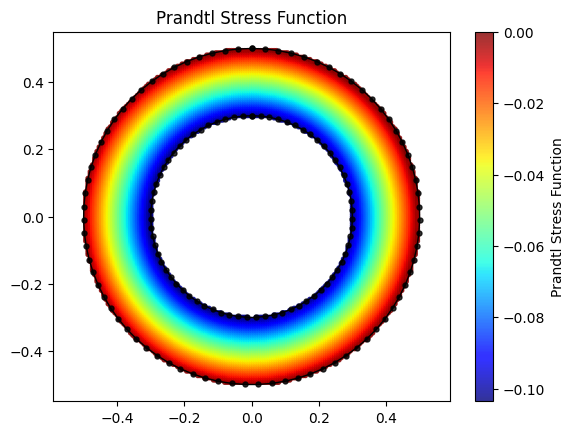

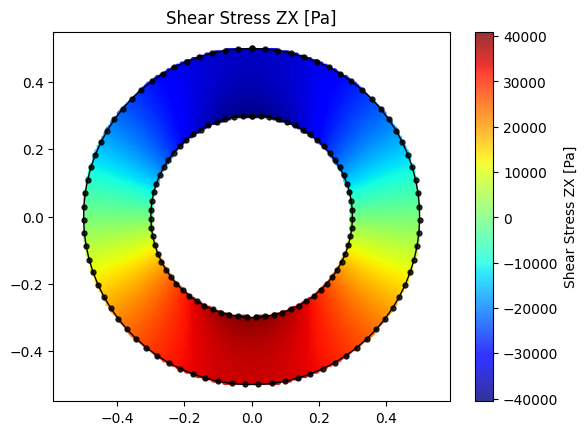

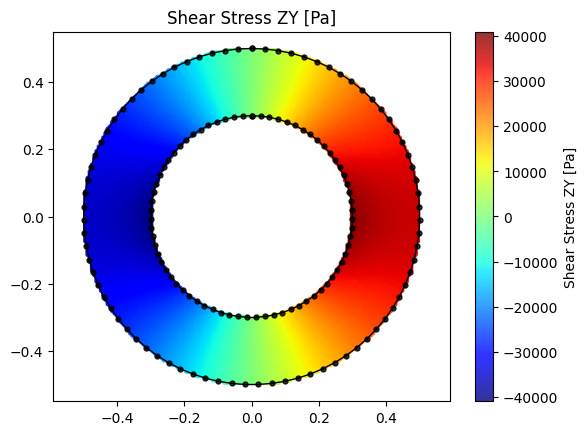

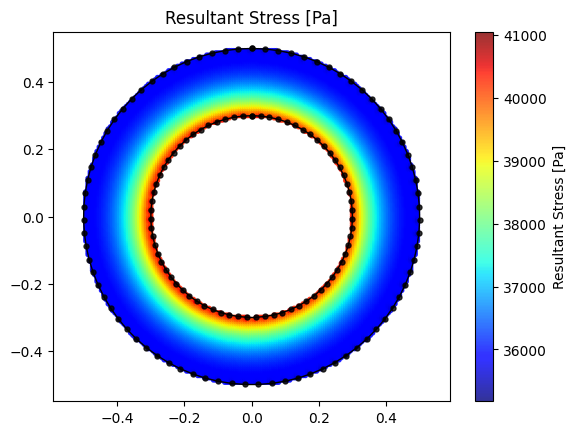

In [244]:
# def plotter(x, y, xbi, xbe, ybi, ybe, h, data, title):
#     plt.figure()
#     plt.scatter(x, y, c=data, cmap='jet')
#     plt.colorbar(label=title)
#     plt.title(title)

#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.show()

def plotter(x, y, xbi, xbe, ybi, ybe, h, f, name):
    maxnumx = (max(x) - min(x)) / h
    maxnumy = (max(y) - min(y)) / h
    maxnum = max(maxnumx, maxnumy)
    scattersize = 400**2 / maxnum**2 + 1.2
    n = len(xbi)

    plt.figure()
    scatter = plt.scatter(x, y, s=scattersize, c=f, cmap='jet',  linewidths=1, alpha=0.8)
    for i in range(n):
        xx = [xbi[i], xbe[i]]
        yy = [ybi[i], ybe[i]]
        plt.plot(xx, yy, color='k', linewidth=1)

    cbar = plt.colorbar(scatter, label=name)
    plt.scatter(xbi, ybi, s=1.5 * scattersize, c='k', marker='o', edgecolors='k', linewidths=1, alpha=0.8)
    plt.axis('equal')
    plt.title(name)
    plt.show()

# Assuming x, y, xbi, xbe, ybi, ybe, h, u, Sxz, Syz, StressRes are already defined
plotter(x, y, xbi, xbe, ybi, ybe, h, u, "Prandtl Stress Function")
plotter(x, y, xbi, xbe, ybi, ybe, h, Sxz, "Shear Stress ZX [Pa]")
plotter(x, y, xbi, xbe, ybi, ybe, h, Syz, "Shear Stress ZY [Pa]")
plotter(x, y, xbi, xbe, ybi, ybe, h, StressRes, "Resultant Stress [Pa]")

In [250]:
min(u)

-0.1035234585033711

In [243]:
# Analytical solution circle
def analytical_solution(x, y, T):
    return 2 * T / (np.pi*0.5*0.5) * np.sqrt(x**2/0.5**4 + y**2/0.5**4)

# Calculate L2 norm error
def calculate_l2_error(numerical, analytical):
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical)

# Analytical solution for the stress
analytical_stress = analytical_solution(x, y, T)

# Calculate L2 norm error for StressRes
l2_error_stress = calculate_l2_error(StressRes, analytical_stress)

print(f"L2 Error for StressRes: {l2_error_stress}")



L2 Error for StressRes: 0.43219396017764217


In [249]:
# Analytical solution hollowed circle
def analytical_solution(x, y, T):
    r2 = 0.5
    t = 0.2
    r = np.sqrt(x**2 + y**2)

    I = np.pi / 4 * (0.5**4 - 0.3**4)
    print(I)
    return T * r / I

# Calculate L2 norm error
def calculate_l2_error(numerical, analytical):
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical)

# Analytical solution for the stress
analytical_stress = analytical_solution(x, y, T)

# Calculate L2 norm error for StressRes
l2_error_stress = calculate_l2_error(StressRes, analytical_stress)

print(f"L2 Error for StressRes: {l2_error_stress}")

0.04272566008882119
L2 Error for StressRes: 0.7489843400599406


In [230]:
# Analytical solution trianle
def analytical_solution(x, y, T):

    return 5*np.sqrt(3) / 27 * T * (x-1) * y

# Calculate L2 norm error
def calculate_l2_error(numerical, analytical):
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical)

# Analytical solution for the stress
analytical_stress = analytical_solution(x, y, T)

# Calculate L2 norm error for StressRes
l2_error_stress = calculate_l2_error(Sxz, analytical_stress)

print(f"L2 Error for StressRes: {l2_error_stress}")

print(max(StressRes))
print(5*np.sqrt(3)*T/(18))

L2 Error for StressRes: 0.010434181240748882


In [238]:
print(max(StressRes))
print(2 * T  / (np.pi * 0.5**3) * 1 / (1 - (0.6)**4))


76322.33381162985
87769.27008744229


76322.33381162985
7216.878364870321


In [ ]:
max(StressRes)

In [ ]:
print(ki_raw)